# Visualizations for RECIST vs. PyRadiomics Measurements

## Dependencies

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

from damply import dirs 
from pathlib import Path

## Load Data

In [62]:
area = ""
dataset = "PMCC_OCTANE"

matched_pyrad_ann_file = dirs.PROCDATA / area / dataset / Path("metadata/recist_diameter_stats/matched_pyradiomics_annotations.csv")

pyrad_ann_df = pd.read_csv(matched_pyrad_ann_file)

num_ann = pyrad_ann_df.shape[0]

In [24]:
#If you want to get all dataset information, run the following code instead of the block above 
area = "Crowds_Cure_Cancer_2018Subset"
dataset = "Crowds-Cure-2018"
areas = ["Abdomen", "Abdomen", "Lung"]
datasets = ["TCIA_CPTAC-CCRCC", "TCIA_CPTAC-PDA", "TCIA_NSCLC-Radiogenomics"]

pyrad_ann_df = pd.DataFrame()
for i in range(len(areas)): 
    curr_path = dirs.PROCDATA / areas[i] / datasets[i] / Path("metadata/recist_diameter_stats/matched_pyradiomics_annotations.csv")
    curr_data = pd.read_csv(curr_path)
    pyrad_ann_df = pd.concat([pyrad_ann_df, curr_data])

pyrad_ann_df.shape[0]

126

## Visualize Raw Data

### Setting Up Label and Save Parameters

In [49]:
num_ann = pyrad_ann_df.shape[0] #Number of tumour annotations in current cohort

pyrad_feature = "original_shape_Maximum2DDiameterSlice"
pyrad_feat_label = pyrad_feature.split("_")[-1]

save_folder = Path("/home/bhkuser/bhklab/kaitlyn/recist-vs-reality/data/results/" + dataset + "/visualization/recist_vs_pyradiomics/" + pyrad_feat_label)

if not save_folder.exists(): 
    save_folder.mkdir(parents=True, exist_ok=True)

### Scatter Plot: Pyradiomics Measurement vs. RECIST Measurement

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_257019/1028563503.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("PyRadiomics " + pyrad_feat_label + " ($\mathregular{mm^3}$)")


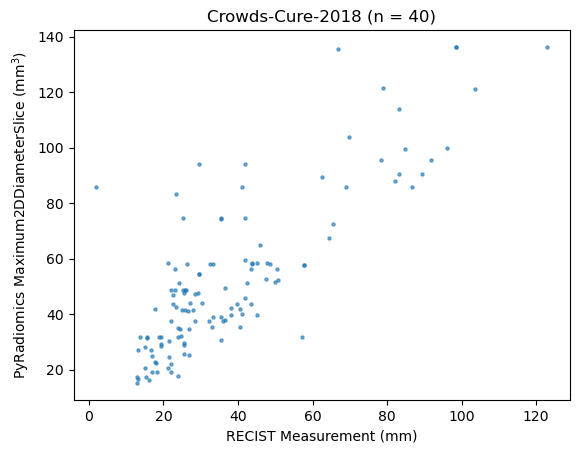

In [26]:
plt.scatter(pyrad_ann_df["AnnLongAxisLength"], pyrad_ann_df[pyrad_feature], s = 5, alpha = 0.6)
plt.xlabel("RECIST Measurement (mm)")
plt.ylabel("PyRadiomics " + pyrad_feat_label + " ($\mathregular{mm^3}$)")
plt.title(dataset + " (n = " + str(num_ann) + ")")
plt.savefig(save_folder / "RECIST_vs_PyRad_Scatter.png", bbox_inches = 'tight')

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_257019/3479260402.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Volume ($\mathregular{mm^3}$)")


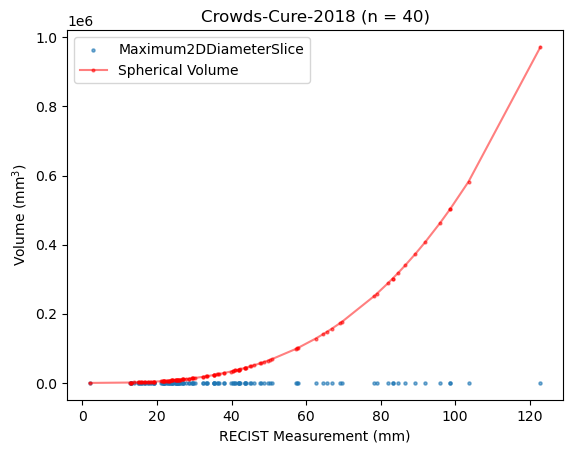

In [27]:
#Plot volume of the expected sphere to see difference between it and the actual volume 
import numpy as np

#Need to order indices for proper line graph for spherical volumes 
sorted_ann_indices = np.argsort(pyrad_ann_df["AnnLongAxisLength"].to_numpy())
sorted_ann_lengths = pyrad_ann_df["AnnLongAxisLength"].to_numpy()[sorted_ann_indices]
sphere_vols = 4/3 * np.pi * (sorted_ann_lengths/2) ** 3
# pyrad_ann_df["SphereVols"] = 4/3 * np.pi * (pyrad_ann_df["AnnLongAxisLength"]/2) ** 3

plt.scatter(pyrad_ann_df["AnnLongAxisLength"], pyrad_ann_df[pyrad_feature], s = 5, alpha = 0.6, label = pyrad_feat_label)
plt.plot(sorted_ann_lengths, sphere_vols, 'ro-', markersize = 2, alpha = 0.5, label = "Spherical Volume")
plt.xlabel("RECIST Measurement (mm)")
plt.ylabel("Volume ($\mathregular{mm^3}$)")
plt.title(dataset + " (n = " + str(num_ann) + ")")
plt.legend(loc = 'upper left')
plt.savefig(save_folder / "RECIST_vs_PyRad_Scatter_wSphereVol.png", bbox_inches = 'tight')


### Box and Violin Plots

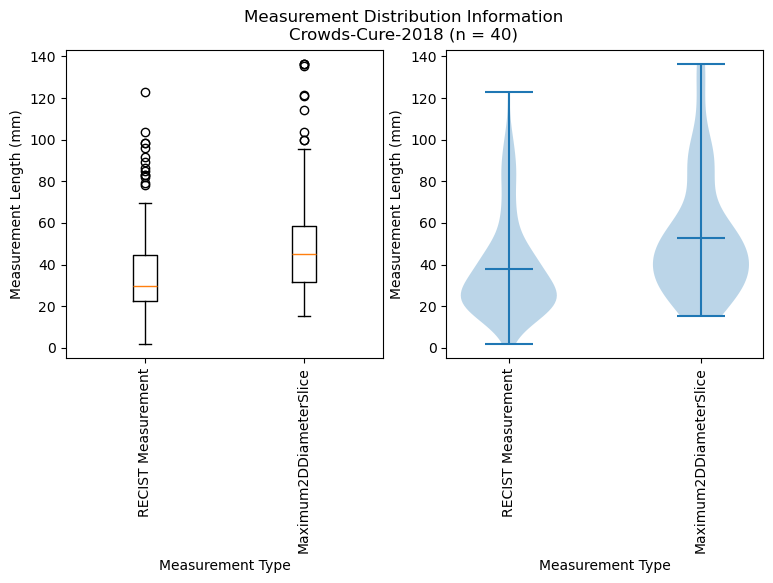

In [28]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9, 4))

#Box plot
ax[0].boxplot(pyrad_ann_df[["AnnLongAxisLength", pyrad_feature]])
ax[0].set_xticks([1, 2],["RECIST Measurement", pyrad_feat_label], rotation = 90)
ax[0].set_ylabel("Measurement Length (mm)")
ax[0].set_xlabel("Measurement Type")

#Violin plot 
ax[1].violinplot(pyrad_ann_df[["AnnLongAxisLength", pyrad_feature]],
                 showmeans=True, 
                 showmedians=False)
ax[1].set_xticks([1, 2],["RECIST Measurement", pyrad_feat_label], rotation = 90)
ax[1].set_ylabel("Measurement Length (mm)")
ax[1].set_xlabel("Measurement Type")
fig.suptitle("Measurement Distribution Information\n" + dataset + " (n = " + str(num_ann) + ")")
fig.savefig(save_folder / "Measurement_Distribution_Box_Violin.png", bbox_inches = 'tight') #Makes sure x axis doesn't get cut off

### Scatter Plot Comparison of RECIST Measurements and Pyradiomics Measurements

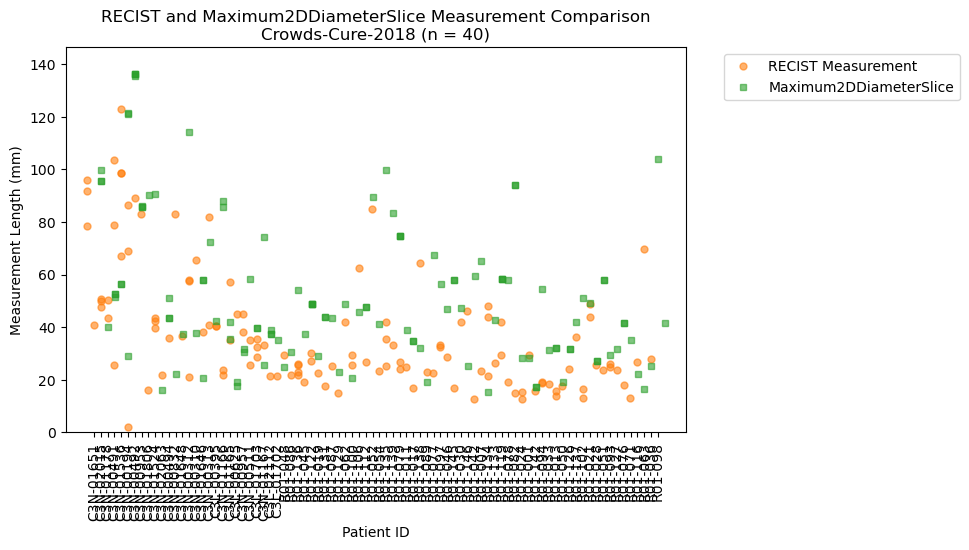

In [29]:
import matplotlib.transforms as transforms

fig, ax = plt.subplots(figsize=(8, 5)) #Change figsize to (12, 5) for NSCLC-Radiogenomics, otherwise (8, 5)

#This is to get the scatter points to appear beside each other. Have to plot temporary points for this to work for some reason
offset = lambda p: transforms.ScaledTranslation(p / 72., 0, plt.gcf().dpi_scale_trans)
temp_points = ax.plot(pyrad_ann_df["PatientID"], pyrad_ann_df["AnnLongAxisLength"], ms = 10, ls = " ", marker = ".")
for pnt in temp_points:
    pnt.remove()

#Plot the data of interest
ax.plot(pyrad_ann_df["PatientID"], pyrad_ann_df["AnnLongAxisLength"], 
            ms = 5, 
            marker = "o", 
            ls = " ", #Makes sure there are no lines connecting the dots
            transform=ax.transData + offset(-5),
            alpha = 0.6,
            label = "RECIST Measurement")
ax.plot(pyrad_ann_df["PatientID"], pyrad_ann_df[pyrad_feature], 
            ms = 5, 
            marker = "s", 
            ls = " ",
            transform=ax.transData + offset(5),
            alpha = 0.6,
            label = pyrad_feat_label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#Adjust the y axis limits in case there are some pyradiomics measurements that are much larger than the annotation length
plt.ylim((0, max(pyrad_ann_df["AnnLongAxisLength"].values.tolist() + pyrad_ann_df[pyrad_feature].values.tolist()) + 10))
plt.xticks(rotation = 90)
plt.xlabel("Patient ID")
plt.ylabel("Measurement Length (mm)")
plt.title("RECIST and " + pyrad_feat_label + " Measurement Comparison\n" + dataset + " (n = " + str(num_ann) + ")")
plt.savefig(save_folder / "RECIST_vs_PyRad_Measure_Compare.png", bbox_inches = 'tight')

### Differences in RECIST Measurement vs. Pyradiomics Measurement

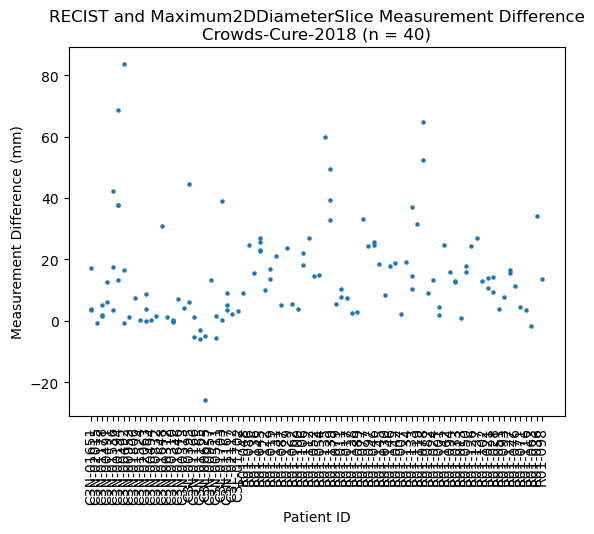

In [30]:
pyrad_ann_df["MeasurementDiff"] = pyrad_ann_df[pyrad_feature] - pyrad_ann_df["AnnLongAxisLength"]

# fig = plt.figure(figsize = (12,5)) #Only needed for NSCLC-Radiogenomics which has 74 matches
plt.scatter(pyrad_ann_df["PatientID"], pyrad_ann_df["MeasurementDiff"], s=5)
plt.xticks(rotation = 90)
plt.title("RECIST and " + pyrad_feat_label + " Measurement Difference\n" + dataset + " (n = " + str(num_ann) + ")")
plt.ylabel("Measurement Difference (mm)")
plt.xlabel("Patient ID")
plt.savefig(save_folder / "RECIST_PyRad_Measurement_Difference.png", bbox_inches = 'tight')

In [31]:
# Calculate relative measurement difference. To be calculated for Maximum2DDiameterSlice measurement only for the moment. 
print(pyrad_feature) #Just sanity check to make sure I'm using the right measurement 

pyrad_ann_df["RelativeMeasurementDiff"] = pyrad_ann_df["MeasurementDiff"] / ((pyrad_ann_df["AnnLongAxisLength"] + pyrad_ann_df[pyrad_feature])/2) * 100 

pyrad_ann_df["RelativeMeasurementDiff"].mean()

original_shape_Maximum2DDiameterSlice


np.float64(33.08907890551958)

### Bland-Altman Analysis

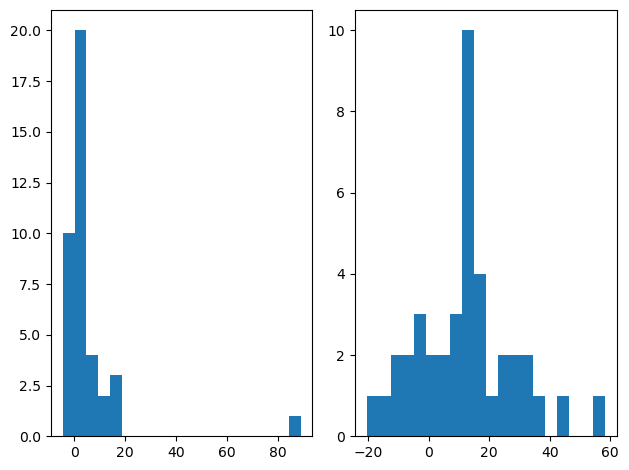

Pval measure diff:  3.3369704720035454e-18
Pval RMD:  0.29999982197487846


In [66]:
#Check normality of both differences 
from scipy.stats import normaltest
#Plot histograms
fig, axs = plt.subplots(1, 2, tight_layout = True) 

axs[0].hist(pyrad_ann_df["MeasurementDiff"], bins = 20)
axs[1].hist(pyrad_ann_df["RelativeMeasurementDiff"], bins = 20)

plt.show()

stat_md, p_md = normaltest(pyrad_ann_df["MeasurementDiff"])
stat_rmd, p_rmd = normaltest(pyrad_ann_df["RelativeMeasurementDiff"])

print("Pval measure diff: ", p_md)
print("Pval RMD: ", p_rmd)

Average Difference (Bias) (mm):  5.568882039378126
Standard Deviation (mm):  14.393910475903986


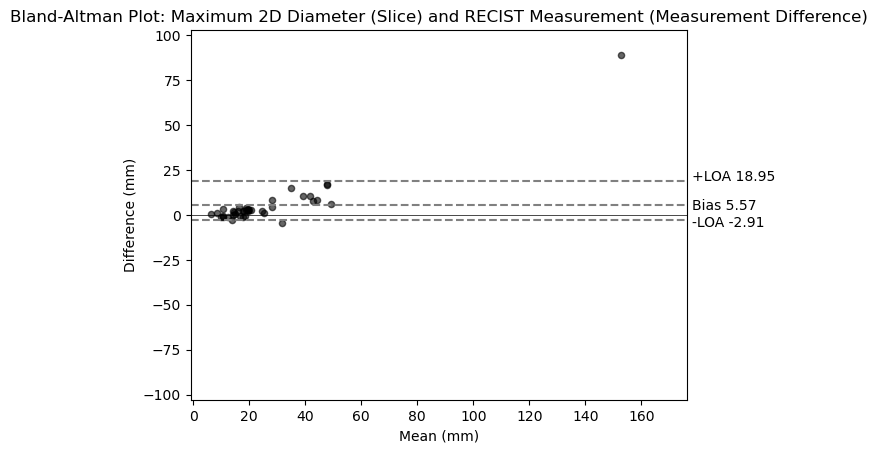

np.float64(14.393910475903986)

In [96]:
#Adopted from this website: https://rowannicholls.github.io/python/statistics/agreement/bland_altman.html#where-to-start-bland-altmans-difference-plot
#Should only be done for Maximum2DDiameterSlice feature

pyrad_ann_df["Means"] = (pyrad_ann_df[pyrad_feature] + pyrad_ann_df["AnnLongAxisLength"])/2
pyrad_ann_df["MeasurementDiff"] = pyrad_ann_df[pyrad_feature] - pyrad_ann_df["AnnLongAxisLength"]

#Calculate bias (average difference)
bias = pyrad_ann_df["MeasurementDiff"].mean()

#Sample standard deviation (assumes differences are normally distributed)
stand_dev = np.std(pyrad_ann_df["MeasurementDiff"], ddof=1)

print("Average Difference (Bias) (mm): ", bias)
print("Standard Deviation (mm): ", stand_dev)

#Calculate limits of agreement (LOAs)
if p_md >= 0.05:
    upper_loa = bias + 1.96 * stand_dev 
    lower_loa = bias - 1.96 * stand_dev
else: 
    upper_loa = np.percentile(pyrad_ann_df["MeasurementDiff"], 97.5)
    lower_loa = np.percentile(pyrad_ann_df["MeasurementDiff"], 2.5)

ax = plt.axes() 
ax.scatter(pyrad_ann_df["Means"], pyrad_ann_df["MeasurementDiff"], c = 'k', s = 20, alpha = 0.6, marker = 'o')

#Plot zero line 
ax.axhline(y = 0, c = 'k', lw=0.5)

#Plot bias and LOAs
ax.axhline(y=lower_loa, c = 'grey', ls='--')
ax.axhline(y=bias, c = 'grey', ls = '--')
ax.axhline(y=upper_loa, c = 'grey', ls = '--')

#Formatting 
ax.set_title("Bland-Altman Plot: Maximum 2D Diameter (Slice) and RECIST Measurement (Measurement Difference)")
ax.set_xlabel("Mean (mm)")
ax.set_ylabel("Difference (mm)")

x_min, x_max = ax.get_xlim()
domain = x_max - x_min
y_min, y_max = ax.get_ylim()
absmax_y = max(abs(y_min), abs(y_max))

ax.set_xlim(x_min, x_min + domain * 1.1)
ax.set_ylim(-absmax_y * 1.1, absmax_y * 1.1)

#Annotations 
ax.annotate("+LOA " + f'{upper_loa:4.2f}', (x_max, upper_loa), (50, 0), textcoords = 'offset pixels')
ax.annotate('Bias ' + f'{bias:4.2f}', (x_max, bias), (50, -5), textcoords='offset pixels')
ax.annotate('-LOA '+ f'{lower_loa:4.2f}', (x_max, lower_loa), (50, -7), textcoords='offset pixels')

plt.show()
stand_dev

Average Difference (Bias) (mm):  12.336274783878272
Standard Deviation (mm):  16.158751942837885


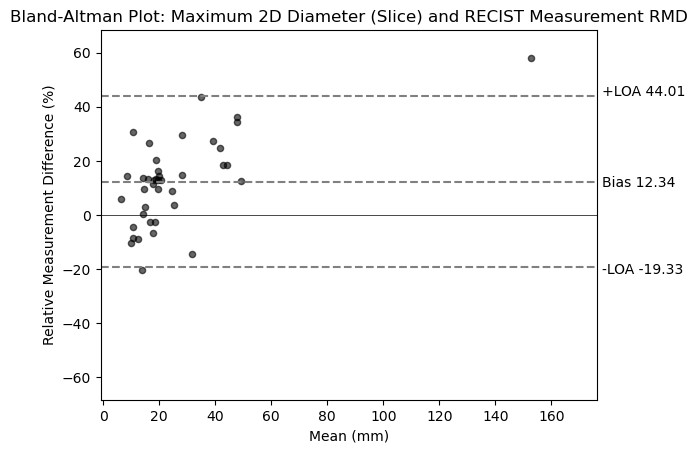

In [98]:
#Repeat above but for the relative measurement difference 

pyrad_ann_df["Means"] = (pyrad_ann_df[pyrad_feature] + pyrad_ann_df["AnnLongAxisLength"])/2
pyrad_ann_df["MeasurementDiff"] = pyrad_ann_df[pyrad_feature] - pyrad_ann_df["AnnLongAxisLength"]
pyrad_ann_df["RelativeMeasurementDiff"] = pyrad_ann_df["MeasurementDiff"] / ((pyrad_ann_df["AnnLongAxisLength"] + pyrad_ann_df[pyrad_feature])/2) * 100 

#Calculate bias (average difference)
bias = pyrad_ann_df["RelativeMeasurementDiff"].mean()

#Sample standard deviation (assumes differences are normally distributed)
stand_dev = np.std(pyrad_ann_df["RelativeMeasurementDiff"], ddof=1)

print("Average Difference (Bias) (mm): ", bias)
print("Standard Deviation (mm): ", stand_dev)

#Calculate limits of agreement (LOAs)
if p_rmd >= 0.05:
    upper_loa = bias + 1.96 * stand_dev 
    lower_loa = bias - 1.96 * stand_dev
else: 
    upper_loa = np.percentile(pyrad_ann_df["MeasurementDiff"], 97.5)
    lower_loa = np.percentile(pyrad_ann_df["MeasurementDiff"], 2.5)

ax = plt.axes() 
ax.scatter(pyrad_ann_df["Means"], pyrad_ann_df["RelativeMeasurementDiff"], c = 'k', s = 20, alpha = 0.6, marker = 'o')

#Plot zero line 
ax.axhline(y = 0, c = 'k', lw=0.5)

#Plot bias and LOAs
ax.axhline(y=lower_loa, c = 'grey', ls='--')
ax.axhline(y=bias, c = 'grey', ls = '--')
ax.axhline(y=upper_loa, c = 'grey', ls = '--')

#Formatting 
ax.set_title("Bland-Altman Plot: Maximum 2D Diameter (Slice) and RECIST Measurement RMD")
ax.set_xlabel("Mean (mm)")
ax.set_ylabel("Relative Measurement Difference (%)")

x_min, x_max = ax.get_xlim()
domain = x_max - x_min
y_min, y_max = ax.get_ylim()
absmax_y = max(abs(y_min), abs(y_max))

ax.set_xlim(x_min, x_min + domain * 1.1)
ax.set_ylim(-absmax_y * 1.1, absmax_y * 1.1)

#Annotations 
ax.annotate("+LOA " + f'{upper_loa:4.2f}', (x_max, upper_loa), (50, 0), textcoords = 'offset pixels')
ax.annotate('Bias ' + f'{bias:4.2f}', (x_max, bias), (50, -5), textcoords='offset pixels')
ax.annotate('-LOA '+ f'{lower_loa:4.2f}', (x_max, lower_loa), (50, -7), textcoords='offset pixels')

plt.show()
